In [38]:
#Import the required Python Libraries
import numpy as np    
import matplotlib.pyplot as plt
%matplotlib inline                    

In [39]:
#Create the plot function agent_plot_performance, to display the trend of the agent's performance 
#from its interaction with the environment
def agent_plot_performance(performance):                      
  rewards = performance["rewards"]
  avg_rewards = performance["avg_rewards"]
  chosen_arms = performance["arms"]   

  fig = plt.figure(figsize=[20,5]) #Customize plot dimension to 5 X 20

  ax0 = fig.add_subplot(1,2,1)  #Using the subplot function. (1,2,1) indicates total no of rows, columns and the figure number 
  ax0.plot(avg_rewards,color='c') #gives a line plot of the avg_rewards shown in cyan color
  ax0.set_xlabel("Number of times played")
  ax0.set_ylabel("Average rewards")
  ax0.set_title("Average Rewards", fontsize=16, fontweight = "bold") # Sets the title of the first plot as Average Rewards  

  ax1 = fig.add_subplot(1,2,2)
  ax1.bar([i for i in range(len(chosen_arms))],chosen_arms,color='c', label="chosen arms") #Plots a list of the chosen arms
  ax1.set_xlabel("arm_count")
  ax1.set_ylabel("Number of times played")
  ax1.set_title("Chosen Actions", fontsize = 16, fontweight="bold") #Sets the title of the second plot as Chosen Actions

In [40]:
#Create an environment for the agent
class Env(object): 

  def __init__(self, reward_probas, rewards):  
    #reward_probas is a list of the probabilities of achieving a reward from each arm.
    #rewards is a list of the actual rewards that can be achieved from each of the arms.
    if len(reward_probas) != len(rewards): 
#raise this error message because the environmnt becomes an invalid one if the condition above is not met
      raise Exception(f"size of reward_probas : {len(reward_probas)} does not match size of rewards: {len(rewards)}") 
    else:
      self.reward_probas = reward_probas 
      self.rewards = rewards  
      self.n_arms = len(reward_probas) #The environment should be aware of the number of arms availabe
#n_arms(10 arms used in this project). Hence,#the number of arms available to the agent is assigned to the 
#length of either reward_probas or rewards since they are equal                                       

  def choose_arm(self, arm):  #Creates a function choose_arm to specify the arm the agent wants to pull. 
                              #here the agent can choose between the arm 0 to the 9th arm
    if arm < 0 or arm > self.n_arms:
      raise Exception(f"arm must be a value between 0 and {self.n_arms -1}") #raise this error if the 'if'  condition is True.
    else:
      return self.rewards[arm] if np.random.random() < self.reward_probas[arm] else 0.0 #Generate a random number. 
#if the random number is less than the reward probability for the selected arm,
#the agent gets rewarded for the arm. Otherwise, it does not get any reward 

In [41]:
#Testing the environment with assumed values of probability distribution for list of reward_probas and actual rewards 
environment = Env(reward_probas=[0.01, 1.0, 0.75, 0.99, 0.65, 1.0, 0.8, 0.05, 0.4, 0.08], \
                  rewards=[95.0, 0.0, 25.5, 20.05, 5.45, 2.50, 30.0, 55, 48, 85])
#From the list, number of arms = 10. the index for each value in the list of reward_probas 
#is equivalent to the same index in the list of rewards.
#This shows the probability distribution of achieving a reward for each arm when pulled. 
#arm 1 has a probability of 0.01 to achieve a reward of 95, 
#while arm 2 has a 100% chance of achieving no reward when pulled, and so on.
print(f"Reward Probas\t\t: {environment.reward_probas}")
print(f"Rewards \t\t: {environment.rewards}")

Reward Probas		: [0.01, 1.0, 0.75, 0.99, 0.65, 1.0, 0.8, 0.05, 0.4, 0.08]
Rewards 		: [95.0, 0.0, 25.5, 20.05, 5.45, 2.5, 30.0, 55, 48, 85]


In [42]:
#Pulling an arm for a certain number of times
[environment.choose_arm(0) for i in range(10)] #Pulling the first arm 10 times
[environment.choose_arm(2) for i in range(10)]


[0.0, 25.5, 25.5, 25.5, 25.5, 0.0, 25.5, 0.0, 25.5, 25.5]

In [43]:
# Creating a random agent that will interact with the environment as 
#the basis of comparisonfor the intelligent agent's performance. 
# The random agent explores only
class RandomAgent(object):
 
  def __init__(self, env, max_iterations=3000):  #specifying how many times the random agent is allowed to interact 
                                                    #with the environment
    self.env = env    #Passing an instance of the environment to the random agent
    self.iterations = max_iterations

  def act(self):  # Creating the function that allows the agent act within the environment and take an optimal decision. 
    arm_counts = np.zeros(self.env.n_arms) #creating a list to store the number of times the random agent is pulling each arm
    rewards = [] #list of all the actual rewards the random agent will achieve on each time step
    avg_rewards = [] #list of the average of all the reward achieved by the agent over time.  

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.n_arms)   #random agent makes a random choice of which arm to pull
      reward = self.env.choose_arm(arm)  #The reward achieved by pulling the chosen arm from the reward value list  

      arm_counts[arm] += 1    #Increase the arm_count for each arm the agent pulls by 1. 
                                #This is to capture number of times the random agent pulls any particular arm
      rewards.append(reward)     #append the reward achieved from choosing an arm from each time step to the list of rewards
      avg_rewards.append(sum(rewards)/ len(rewards)) #append the average of all the rewards achieved to the avg_rewards list

    return {"arms": arm_counts, "rewards": rewards, "avg_rewards": avg_rewards}  #return a dictionary to be used by the plotting 
                                                                                    #function in code block 2


In [44]:
#Creating an instance of the random agent to learn how it behaves. Here, the agent explores only.
random_agent = RandomAgent(env=environment, max_iterations=3000)
ra_performance = random_agent.act()    #Using the act() function to make the random agent to act on the environment.
print(f"TOTAL REWARD : {sum(ra_performance['rewards'])}")#determine the total reward earned by the agent after 3000 iterations

TOTAL REWARD : 29140.549999999952


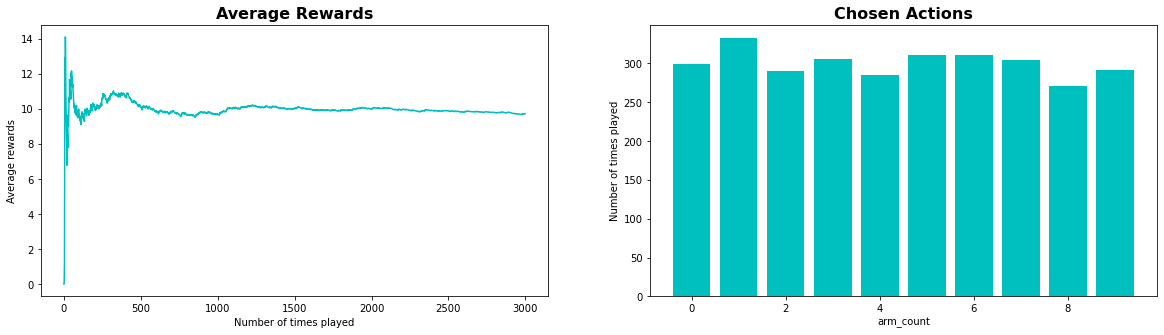

In [45]:
agent_plot_performance(ra_performance) #Here, the Agent Explores only


In [46]:
#Creating an intelligent agent called the EpsilonGreedyAgent. 
class EpsilonGreedyAgent(object):

  def __init__(self, env, max_iterations=3000, epsilon=0.01): #defining the class and getting the agent to explore 
                                                                #with a probability of 0.01
    self.env = env 
    self.iterations = max_iterations
    self.epsilon = epsilon 
     

  def act(self):
    q_values = np.zeros(self.env.n_arms)    #Payrate for each of the arms 
    arm_rewards = np.zeros(self.env.n_arms) #Total reward from each arm
    arm_counts = np.zeros(self.env.n_arms)  #Count of the number of times each arm is pulled. 

    rewards = []
    avg_rewards = [] 

    for i in range(1, self.iterations + 1):
#EpsilonGreedyAgent to generate a random number and check,if the random number is less than the epsilon probability
#take a random action. Otherwise, take the action with the maximum pay rate.
      arm = np.random.choice(self.env.n_arms) if np.random.random() < self.epsilon else np.argmax(q_values) 
    
                                                            
                                                                                                                
      reward = self.env.choose_arm(arm)   #specifies the arm the agent is choosing                                                                 
      arm_rewards[arm] += reward          #increase the total reward obtained by pulling the particular arm selected                                                                       
      arm_counts[arm] += 1                #Indicates the number of times the arm was chosen
    
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]                                                            
      rewards.append(reward)
      avg_rewards.append(sum(rewards)/ len(rewards)) 

    return {"arms": arm_counts, "rewards": rewards, "avg_rewards": avg_rewards}


In [47]:
#Creating an instance of the EpsilonGreedyAgent algorithm
egreedy_agent = EpsilonGreedyAgent(environment, max_iterations=3000, epsilon=0.09) 
#using an epsilon value of 0.09 here shows that we want the agent to explore more and make most of the rewards.
eg_performance = egreedy_agent.act() 
print(f"TOTAL REWARD : {sum(eg_performance['rewards'])}")

TOTAL REWARD : 67197.6


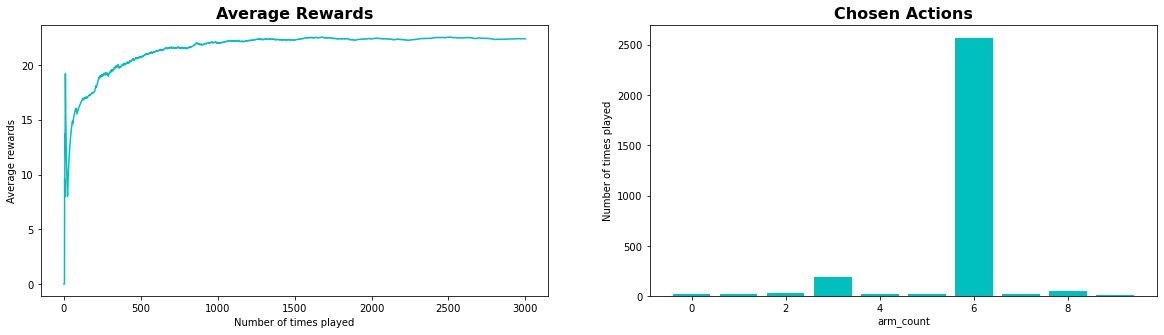

In [48]:
#Plotting the Epsilon greedy agent performance in the environment
agent_plot_performance(eg_performance)

In [49]:
#Epsilon Greedy Agent with decay 
class EpsilonGreedyAgent(object):
#defining the class and getting the agent to explore with a probability of 0.09
  def __init__(self, env, max_iterations=3000, epsilon=0.09, decay = 0.05, decay_interval = 100): 
    self.env = env 
    self.iterations = max_iterations
    self.epsilon = epsilon 
    self.decay = decay
    self.decay_interval = decay_interval
     

  def act(self):
    q_values = np.zeros(self.env.n_arms)    #Payrate for each of the arm is assumed to be zero initially 
    arm_rewards = np.zeros(self.env.n_arms) #Total reward from each arm
    arm_counts = np.zeros(self.env.n_arms)  #Count of the number of times each arm is pulled. 

    rewards = []
    avg_rewards = [] 

    for i in range(1, self.iterations + 1):
#EpsilonGreedyAgent to generate a random number and check if the random number is less than the epsilon probability 
#take a random action. Otherwise, take the action with the maximum pay rate.       
      arm = np.random.choice(self.env.n_arms) if np.random.random() < self.epsilon else np.argmax(q_values)  
     
      reward = self.env.choose_arm(arm)   #specifies the arm the agent is choosing                                                                 
      arm_rewards[arm] += reward          #increase the total reward obtained by pulling the particular arm selected                                                                       
      arm_counts[arm] += 1                #Indicates the number of times the arm was chosen
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]   #using the arm_rewards and arm_counts to evaluate the q_value 
                                                        #for the particular arm chosen
                                                         #which gives an estimate of how valuable the particular 
                                                        #arm is to the intelligent agent
      rewards.append(reward)
      avg_rewards.append(sum(rewards)/ len(rewards)) 
    
      if i % self.decay_interval == 0:
            self.epsilon = self.epsilon * self.decay #reducing the rate at which the agent explores

    return {"arms": arm_counts, "rewards": rewards, "avg_rewards": avg_rewards}


In [50]:
#Creating an instance of the EpsilonGreedyAgent with decay algorithm
#Epsilon is set as 0.2 to make the exploration faster
egreedy_decay_agent = EpsilonGreedyAgent(environment, max_iterations=3000, epsilon=0.2, decay = 0.05) 
egd_performance = egreedy_decay_agent.act() #Getting our agent to act on the environment 
print(f"TOTAL REWARD : {sum(egd_performance['rewards'])}")

TOTAL REWARD : 71463.4


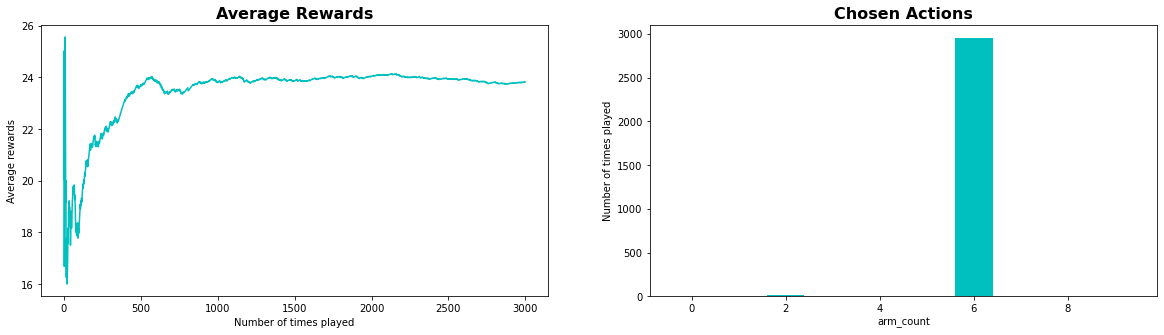

In [51]:
#Plotting the Epsilon greedy agent performance in the environment
agent_plot_performance(egd_performance)